# Tut 2b - Embeddings and similarity scores
#### Welcome back to the Kaggle 5-day Generative AI course!

#### In this notebook you will use the Gemini API's embedding endpoint to explore similarity scores.

## Set up the SDK(Dependencies)


In [1]:
!pip uninstall -qqy jupyterlab kfp 
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 

In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

## Iterate through available models and check for 'embedContent' support
To identify models that support the embedContent method using the models.list endpoint in the Gemini API,

In [5]:
# Initialize the client with your API key
client = genai.Client(api_key=GOOGLE_API_KEY)

for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [9]:
from google.genai.types import EmbedContentConfig

# Texts to embed
texts = [
    'Winter is coming.',
    'The night is dark and full of terrors.',
    'A Lannister always pays his debts.',
    'Dracarys!',
    'The king in the north!',
    'Valar Morghulis. Valar Dohaeris.',
    # Alternative phrase for comparison:
    'When you play the game of thrones, you win or you die.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',  # Unrelated text
]


# Generate embeddings for semantic similarity
response = client.models.embed_content(
    model='text-embedding-004',
    contents=texts,
    config=EmbedContentConfig(task_type='semantic_similarity')
)

# Access embeddings from the response
embeddings = response.embeddings

# Print the first 10 embeddings
#  print(embeddings[:10])

In [12]:
 def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

print(truncated_texts)

['Winter is coming.', 'The night is dark and full of terrors.', 'A Lannister always pays his debts.', 'Dracarys!', 'The king in the north!', 'Valar Morghulis. Valar Dohaeris.', 'When you play the game of thrones, you win or y...', 'Lorem ipsum dolor sit amet, consectetur adipisc...']


<Axes: >

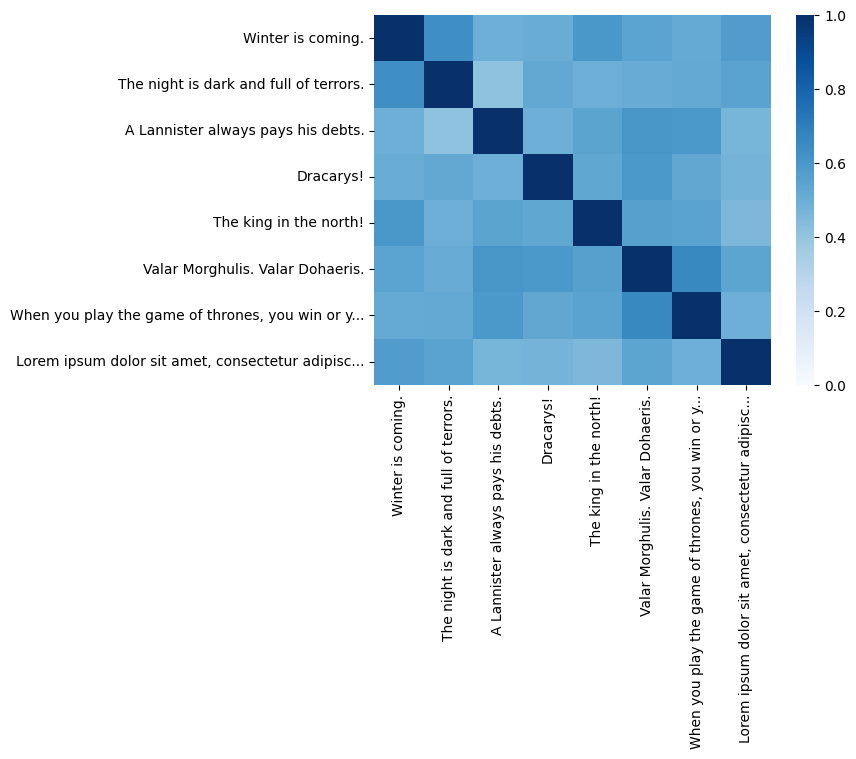

In [14]:
import pandas as pd
import seaborn as sns

# Convert embeddings to DataFrame (rows = texts, columns = embedding dimensions)
df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)

# Calculate similarity matrix using dot product (equivalent to cosine similarity)
similarity_matrix = df @ df.T  # Matrix multiplication of embeddings with transpose

# Visualize as heatmap (0.0-1.0 similarity scale)
sns.heatmap(similarity_matrix, vmin=0, vmax=1, cmap="Blues")


## Purpose of the Heatmap:
The *heatmap* is used to visually represent the *similarity scores* between embedding vectors. Each cell in the heatmap corresponds to the *cosine similarity between two texts*, with values ranging from *0.0 (completely dissimilar)* to *1.0 (completely similar)*. This is particularly useful for analyzing semantic relationships between texts.

In [15]:
# Look up similarity scores for the text "Winter is coming."
scores = similarity_matrix.loc['Winter is coming.'].sort_values(ascending=False)

# Display the scores
print(scores)


Winter is coming.                                     0.999999
The night is dark and full of terrors.                0.636584
The king in the north!                                0.600387
Lorem ipsum dolor sit amet, consectetur adipisc...    0.581307
Valar Morghulis. Valar Dohaeris.                      0.549520
When you play the game of thrones, you win or y...    0.518678
Dracarys!                                             0.504212
A Lannister always pays his debts.                    0.495866
Name: Winter is coming., dtype: float64
